# Rapport Challenge Kaggle
***
## Présentation du Problème 

Le concours "EEG Signal Quality Analysis", organisé par Beacon Biosignals, invite les participants à concevoir des algorithmes capables d'évaluer avec précision la qualité des signaux d'électroencéphalogramme (EEG). 

L'EEG est une méthode non invasive qui enregistre l'activité électrique du cerveau et qui est largement utilisée dans les milieux cliniques et de recherche pour surveiller la santé neurologique, diagnostiquer des troubles ou étudier les fonctions cognitives. Cependant, les enregistrements EEG sont souvent perturbés par des artefacts provenant de diverses sources, telles que les mouvements musculaires, ou les interférences environnementales, ce qui peut affecter la fiabilité des données. Par conséquent, une évaluation précise de la qualité des signaux EEG est essentielle pour que l’analyse et les interprétations faites portent bien sur les phénomènes réels que l’on souhaite isoler, et non ces artefacts.

Le but est donc de développer une méthode statistique permettant de détecter automatiquement si un enregistrement est de bonne ou mauvaise qualité.


In [1]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from utils import butter_bandpass_filter, reshape_signal_into_windows
from scipy.stats import skew


## Présentation du Dataset
***
Le dataset dont nous disposons est composé de plusieurs enregistrements échantillonnés à 250 Hz. Chaque enregistrement comporte les signaux de 5 canaux (correspondant à 5 éléctrodes différentes) et est annoté manuellement par des experts. 

Les annotations sont transformées en masques de segmentation par intervalles de 2 secondes. Chaque segment est étiqueté pour chaque canal :

- 0 : Mauvaise qualité majoritaire.

- 1 : Bonne qualité majoritaire.

Ainsi, chaque tranche de 2 secondes contient cinq étiquettes, correspondant aux cinq canaux EEG.


### Data loading

In [2]:
ROOT_PATH = Path("train/")
training_data = [(np.load(ROOT_PATH / f"data_{i}.npy"),np.load(ROOT_PATH / f"target_{i}.npy")) for i in range(4)]

## Mise en forme et préprocessing des données 
***
Etant donné le dataset d’enregistrement, la première question qui s’est posée est de savoir si nous voulions analyser les enregistrements en entiers, par tranches de 2 secondes (correspondant à une annotation unique), tranches de 6 secondes, etc…
Se pose également la question de si nous souhaitions analyser les canaux ensembles (ce qui permettrait potentiellement de croiser les données des 5 canaux, les comparer et aboutir à une modélisation jointe) ou plutôt un à un indépendamment. 
Au vu de la simplicité relative et après un certain de nombre de tests préliminaires, nous avons décidé d’analyser les canaux un à un et dans des tranches de 2 secondes. 

Par ailleurs, nous utilisons un filtre passe bande de Butterworth de paramètres [A remplir] afin de lisser notre signal (éliminer les composantes hautes fréquences) tout en préservant la qualité de notre signal sur les fréquences d’intérêt.

Une fois les enregistrements correctement découpés et lissés, nous cherchons à présent des features du signal qui peuvent être d’intérêt pour l’étude que nous souhaitons faire. 


In [5]:
all_data = []
all_targets = []
for (data,target) in training_data:
    filtered_data =  butter_bandpass_filter(data,0.1,18,250,4)
    reshaped_data = reshape_signal_into_windows(filtered_data,250,2)
    targets_flatten = target[..., :len(reshaped_data[0])].reshape(-1)
    reshaped_data = reshaped_data.reshape((-1,reshaped_data.shape[-1]))
    all_data.append(reshaped_data)
    all_targets.append(targets_flatten)
all_data = np.concatenate(all_data)
all_targets = np.concatenate(all_targets)
assert all_data.shape[0] == all_targets.shape[0]

print(f"The number of samples is {all_data.shape[0]}")


The number of samples is 261755


## Recherche de Features
***
Un certain de nombre de features nous est apparu comme immédiat. Nous avons complété ces choix intuitifs avec des éléments que nous avons pu trouver dans Sleep Stage Classification Using EEG Signal Analysis: A Comprehensive Survey and New Investigation. 
Les premières features qui se sont imposées étaient : 
- L’amplitude
- Le min / Le max du signal
- La moyenne et l’écart type du signal
- La Wavelet Energy : mesure de l'énergie contenue dans un signal à différentes échelles et moments dans le temps, basée sur la décomposition sur la base d’ondelettes, et utile pour les signaux non stationnaires (comme les EEG dont les caractéristiques peuvent évoluer dans le temps)
- Le spectre de puissance (Fourier energy) : mesure de la distribution de la puissance (ou énergie) du signal en fonction de la fréquence, obtenue via la transformée de Fourier. Il peut être utile pour les signaux stationnaires afin d’identifier les fréquences dominantes (par exemple, les rythmes alpha ou beta dans les EEG).

Le papier mentionné précédemment a ajouté à cette liste : 
- La distance 2D : Au lieu de mesurer la différence entre le min et le max et obtenir l’amplitude du signal, on mesure la distance en 2D entre le min et le max, ce qui donne une indication sur l’amplitude du signal ainsi que sur sa concentration.
- L'Esis : mesure qui suppose que le signal possède une vitesse et une énergie. La vitesse est calculée à partir de la fréquence centrale de chaque bande et de la longueur d'onde du signal EEG. Cette vitesse est ensuite multipliée par le carré des amplitudes du signal pour chaque échantillon. Enfin, l'Esis total est obtenu en additionnant ces valeurs.

Nous ajoutons également un ensemble de features supplémentaires :

- Le rapport signal/bruit dans une bande de fréquences spécifique (SNR) : Un indicateur de la clarté du signal dans une plage donnée (par exemple, la bande alpha entre 8-12 Hz) par rapport au bruit environnant.
- Le ratio de bruit haute fréquence : Proportion de l'énergie contenue dans les hautes fréquences (au-dessus de 100 Hz) par rapport à l'énergie totale du signal. Cet indicateur peut révéler des artefacts dus aux muscles ou aux interférences.
- Le ratio de bruit de ligne électrique : Proportion de l'énergie concentrée autour de la fréquence du réseau électrique (typiquement 50 Hz ou 60 Hz) par rapport à l'énergie totale. Cette mesure aide à quantifier l'impact des interférences électriques sur les enregistrements EEG.
- La dimension fractale (Higuchi) : Une mesure de la complexité du signal, calculée à partir de la dimension fractale, qui évalue la rugosité du signal sur plusieurs échelles temporelles.
Ces features, combinées, permettent de caractériser le signal EEG en profondeur, en intégrant des mesures temporelles, fréquentielles, énergétiques, ainsi que des indicateurs de bruit ou de complexité.


In [40]:
import numpy as np
import scipy.signal
import pywt
import pywt


def compute_distances_2d(all_data, window_size=100):
    """
    Computes the sum of 2D distances (max_idx-min_idx and max_val-min_val)
    over sub-windows of length `window_size`.
    Returns an array of shape [N] if all_data.shape is (N, T).
    """
    num_windows = all_data.shape[-1] // window_size
    distances_2d = 0  # scalar (will broadcast to array once added to np arrays)
    
    for i in range(num_windows):
        sub_window = all_data[..., i * window_size : (i + 1) * window_size]

        max_values = np.max(sub_window, axis=-1)
        min_values = np.min(sub_window, axis=-1)
        max_indices = np.argmax(sub_window, axis=-1)
        min_indices = np.argmin(sub_window, axis=-1)

        distances_2d += np.sqrt((max_indices - min_indices)**2 + (max_values - min_values)**2)

    return distances_2d


def compute_wavelet_energy_features(all_data, wavelet='db4', level=4):
    """
    Compute wavelet energy for each 1D array in all_data.
    Returns a list/array of wavelet energies, one per row/signal of all_data.
    """
    wavelet_list = []
    for signal in all_data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        energy_details = [np.sum(np.array(detail) ** 2) for detail in coeffs[1:]]
        wavelet_list.append(np.sum(energy_details))
    return wavelet_list


def compute_mean_value(all_data):
    """
    Compute the mean over the last axis, then flatten.
    """
    return np.mean(all_data, axis=-1).reshape(-1)


def compute_std_dev(all_data):
    """
    Compute the std dev over the last axis, then flatten.
    """
    return np.std(all_data, axis=-1).reshape(-1)


def compute_amplitude(all_data):
    """
    Compute the difference between max and min over the last axis, then flatten.
    """
    return (np.max(all_data, axis=-1) - np.min(all_data, axis=-1)).reshape(-1)



def compute_esis_features(all_data, frequency=1.0, wavelength=1.0):
    """
    Compute the Esis feature for each 1D array in all_data.
    
    Esis = v * sum(X^2), where v = frequency * wavelength.
    By default, frequency=1.0 and wavelength=1.0, but you may override them
    or compute them per band.
    
    Parameters
    ----------
    all_data : array-like
        A 2D array of shape (num_signals, num_samples) or similar.
    frequency : float
        The midpoint frequency for the band.
    wavelength : float
        The wavelength of the signal in that band.
    
    Returns
    -------
    esis_list : list
        The list of Esis values, one per row in all_data.
    """
    v = frequency * wavelength  # velocity
    esis_list = []
    
    for signal in all_data:
        # Esis = sum of X^2 multiplied by v
        esis_value = np.sum(np.square(signal)) * v
        esis_list.append(esis_value)
    
    return esis_list


def compute_power_spectrum(all_data, fs=250):
    """
    Computes the total power spectrum (via Welch's method) for each 1D array in all_data.
    Returns a list of total power spectral densities, one per signal.
    
    Parameters
    ----------
    all_data : array-like
        A 2D array of shape (num_signals, num_samples).
    fs : float
        Sampling frequency of the signals.

    Returns
    -------
    total_power_spectrum_list : list of float
        Each element is the total power spectral density for one signal.
    """
    total_power_spectrum_list = []
    for signal in all_data:
        _, Pxx = scipy.signal.welch(signal, fs=fs)
        total_power_spectrum_list.append(np.sum(Pxx))
    return total_power_spectrum_list




def compute_band_snr(all_data, fs=250.0, band=(8.0, 12.0)):
    """
    Computes a simple SNR measure for a specified frequency band (default: alpha band [8-12 Hz]).
    The function returns one float per segment, measuring how much power is in the band
    relative to the power outside the band.

    Parameters
    ----------
    all_data : ndarray of shape (num_segments, num_frames)
        Single-channel EEG data. Each row is one 2-second segment (e.g. 500 samples).
    fs : float
        Sampling frequency in Hz (default=250).
    band : tuple (low_freq, high_freq)
        The frequency range over which to measure signal power (default alpha range 8-12 Hz).

    Returns
    -------
    snr_values : list of float
        One SNR value per segment.
    """
    low_f, high_f = band
    snr_values = []

    def welch_psd(signal):
        freqs, psd = scipy.signal.welch(signal, fs=fs, nperseg=250)
        return freqs, psd

    def band_power(freqs, psd, low, high):
        idx = np.logical_and(freqs >= low, freqs <= high)
        return np.sum(psd[idx])

    for signal in all_data:
        # Welch's PSD
        freqs, psd = welch_psd(signal)
        # Power in the target band
        p_band = band_power(freqs, psd, low_f, high_f)
        # Total power
        p_total = np.sum(psd)
        # Power outside band
        p_outside = p_total - p_band
        # Simple ratio: SNR = band_power / power_outside
        snr_values.append(p_band / (p_outside + 1e-10))

    return snr_values

def compute_high_freq_noise_ratio(all_data, fs=250.0, cutoff=100.0):
    """
    Computes the ratio of power above `cutoff` Hz to the total power.
    Higher ratios typically indicate muscle or equipment noise.

    Parameters
    ----------
    all_data : ndarray of shape (num_segments, num_frames)
        Single-channel EEG data. Each row is one 2-second segment.
    fs : float
        Sampling frequency in Hz (default=250).
    cutoff : float
        Frequency threshold above which power is considered "high-frequency noise" (default=100 Hz).

    Returns
    -------
    hf_noise_ratios : list of float
        One ratio value per segment.
    """
    hf_noise_ratios = []

    def welch_psd(signal):
        freqs, psd = scipy.signal.welch(signal, fs=fs, nperseg=250)
        return freqs, psd

    for signal in all_data:
        freqs, psd = welch_psd(signal)
        high_freq_indices = freqs >= cutoff
        power_high = np.sum(psd[high_freq_indices])
        power_total = np.sum(psd)
        ratio = power_high / (power_total + 1e-10)
        hf_noise_ratios.append(ratio)

    return hf_noise_ratios

def compute_line_noise_ratio(all_data, fs=250.0, line_freq=50.0, band_width=1.0):
    """
    Computes the ratio of power in a narrow band around the line frequency
    (default 50 Hz, +/- band_width) to the total power.

    Parameters
    ----------
    all_data : ndarray of shape (num_segments, num_frames)
        Single-channel EEG data. Each row is one 2-second segment.
    fs : float
        Sampling frequency in Hz (default=250).
    line_freq : float
        The mains (line) frequency to check (default=50 Hz, can be 60 Hz in some locales).
    band_width : float
        The half-width around `line_freq` to consider (e.g., 50 +/- 1 Hz).

    Returns
    -------
    ln_ratios : list of float
        One line-noise ratio per segment.
    """
    ln_ratios = []

    def welch_psd(signal):
        freqs, psd = scipy.signal.welch(signal, fs=fs, nperseg=250)
        return freqs, psd

    for signal in all_data:
        freqs, psd = welch_psd(signal)
        # Frequencies in [line_freq - band_width, line_freq + band_width]
        idx_line = (freqs >= (line_freq - band_width)) & (freqs <= (line_freq + band_width))
        power_line = np.sum(psd[idx_line])
        power_total = np.sum(psd)
        ln_ratios.append(power_line / (power_total + 1e-10))

    return ln_ratios

def compute_fractal_dimension(all_data, kmax=8):
    """
    Computes Higuchi's Fractal Dimension (HFD) for each signal (single-channel).
    Higuchi's algorithm estimates the waveform's 'roughness' or complexity.

    Parameters
    ----------
    all_data : ndarray of shape (num_segments, num_frames)
        Single-channel EEG data. Each row is one 2-second segment.
    kmax : int
        Maximum interval “k” for constructing the HFD measure (default=8).

    Returns
    -------
    fd_values : list of float
        One fractal dimension value per segment.
    """

    def higuchi_fd(signal, kmax):
        """Compute the Higuchi Fractal Dimension of a 1D signal."""
        n = len(signal)
        Lmk = np.zeros(kmax)
        for k in range(1, kmax + 1):
            Lm = []
            for m in range(k):
                idxs = m + np.arange(0, int((n - m) / k)) * k
                dist = np.sum(np.abs(np.diff(signal[idxs])))
                # Normalization factor from the original Higuchi procedure
                norm_factor = (n - 1) / (len(idxs) * k)
                Lm.append(dist * norm_factor)
            Lmk[k - 1] = np.mean(Lm)

        # Fit a line in log-log space: ln(L(k)) vs ln(k)
        lnL = np.log(Lmk + 1e-10)
        lnk = np.log(np.arange(1, kmax + 1))
        # Slope = fractal dimension
        slope = np.polyfit(lnk, lnL, 1)[0]
        return slope

    fd_values = []
    for signal in all_data:
        fd_values.append(higuchi_fd(signal, kmax))

    return fd_values


In [58]:
feature_functions = {
    "amplitude": compute_amplitude,
    "mean_value": compute_mean_value,
    "std_dev": compute_std_dev,
    "distances_2d": compute_distances_2d,
    "wavelet": compute_wavelet_energy_features,
    "esis" : compute_esis_features,
    "power_spectrum": compute_power_spectrum,
    "band_snr": compute_band_snr,
    "high_freq_noise_ratio": compute_high_freq_noise_ratio,
    "line_noise_ratio": compute_line_noise_ratio,
    "fractal_dimension": compute_fractal_dimension,
}


In [60]:
def build_training_dataframe(all_data, all_targets, feature_functions):
    """
    Computes each feature in feature_functions and returns a single DataFrame.
    """
    feature_dict = {}
    for feature_name, func in feature_functions.items():
        feature_dict[feature_name] = func(all_data)
    
    # Add target
    feature_dict["target"] = all_targets
    
    # Build DataFrame and drop NaNs
    df = pd.DataFrame(feature_dict)
    df = df.dropna()
    return df


training_data = build_training_dataframe(all_data, all_targets, feature_functions)


## Le Random Forest Classifier
Afin de comprendre le Random Forest classifier, il faut d’abord expliquer ce qu’est un Arbre classifieur. Un arbre classifier (dans notre cas à deux classes) est une structure binaire qui part de la racine ou toutes les données sont regroupées, et qui à chaque neoud sélectionne la feature et un seuil qui permet de mieux séparer les deux classes. 
Les hyperparamètres de cette méthode sont entre autre la profondeur maximale de l’arbre, la métrique de séparation, le nombre de features utilisés à chaque séparation.


Le Random forest classifier est une méthode d’ensemble qui vise à entrainer un très grand nombre d’arbres classifieurs à peine meilleurs qu’un classifieur qui choisir au hasard (weak learners) mais dont la synthèse totale des votes est performante. 
Pour cela, chaque arbre hérite d’un échantillon boostrap de l’échantillon entraîné et d’un certain nombre de features, et s’entraine sur ces données limitées. 



In [62]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, 
from sklearn.metrics import (
    make_scorer,
    cohen_kappa_score,
    classification_report,
    confusion_matrix
)

# -----------------------------------------------------------------
# 1) TRAIN/VALIDATION SPLIT
#    Here we assume "training_data" is your full dataset as a DataFrame
#    with one column named "target" and all other columns are features.
# -----------------------------------------------------------------
train_set, val_set = train_test_split(
    training_data,
    test_size=0.30,
    shuffle=True,
    random_state=42  # single seed for reproducibility
)

# Separate features (X) and target (y)
X_train = train_set.drop(columns=["target"]).values
y_train = train_set["target"].values

X_val = val_set.drop(columns=["target"]).values
y_val = val_set["target"].values

# -----------------------------------------------------------------
# 2) SET UP A PIPELINE: PREPROCESSING + MODEL
# -----------------------------------------------------------------
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# -----------------------------------------------------------------
# 3) DEFINE HYPERPARAMETERS + SCORING
#    Use prefix "rf__" to refer to RandomForest step in pipeline
# -----------------------------------------------------------------
param_grid = {
    'rf__n_estimators': [150, 200, 300],
    'rf__max_depth': [10, 12, 15],
    'rf__min_samples_split': [4, 6, 8],
}

scoring = {
    'kappa': make_scorer(cohen_kappa_score),
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro'
}

# -----------------------------------------------------------------
# 4) GRID SEARCH CV
# -----------------------------------------------------------------
cv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='kappa',       # We'll select the best model by 'kappa'
    cv=5,                # 5-fold cross-validation
    verbose=2            # Increase or decrease for logging detail
)

# -----------------------------------------------------------------
# 5) FIT THE GRID SEARCH ON TRAINING DATA
# -----------------------------------------------------------------
cv.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END rf__max_depth=15, rf__min_samples_split=8, rf__n_estimators=300; total time=  49.9s
[CV] END rf__max_depth=15, rf__min_samples_split=8, rf__n_estimators=300; total time=  58.2s
[CV] END rf__max_depth=15, rf__min_samples_split=8, rf__n_estimators=300; total time= 1.1min
[CV] END rf__max_depth=15, rf__min_samples_split=8, rf__n_estimators=300; total time= 1.2min
[CV] END rf__max_depth=15, rf__min_samples_split=8, rf__n_estimators=300; total time=  49.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'rf__max_depth': [15], 'rf__min_samples_split': [8],
                         'rf__n_estimators': [300]},
             refit='kappa',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'kappa': make_scorer(cohen_kappa_score, response_method='predict')},
             verbose=2)

## Validation croisée utilisée

Le protocole de validation croisée employé repose sur une recherche systématique des hyperparamètres à l'aide de GridSearchCV avec une validation croisée à 5 plis.

Comment cela fonctionne :
Le jeu de données d'entraînement (70 % du total, après division initiale) est divisé en 5 sous-ensembles de taille égale.
À chaque itération, 4 sous-ensembles sont utilisés pour entraîner le modèle, tandis que le dernier sert à valider les performances.

Ce processus est répété pour chaque combinaison d'hyperparamètres spécifiée dans la grille.

À la fin, les performances pour chaque combinaison sont moyennées sur les 5 plis pour obtenir une estimation robuste.

Ce protocole a les avantages suivants :
- Réduction de la variance : La validation croisée utilise plusieurs divisions des données, ce qui minimise l'effet des variations dues à un seul split.
- Évaluation robuste : Elle donne une estimation plus fiable des performances réelles du modèle en simulant des scénarios où le modèle est testé sur des données qu'il n'a pas vues.
- Optimisation des hyperparamètres : En explorant systématiquement une grille d'hyperparamètres, ce protocole identifie les combinaisons qui maximisent une métrique cible (ici, le score de Cohen Kappa).
- Équilibre biais-variance : En utilisant la validation croisée, on limite le risque de sur-apprentissage (overfitting) tout en s'assurant que le modèle reste performant sur des données inédites.

Best parameters found: {'rf__max_depth': 15, 'rf__min_samples_split': 8, 'rf__n_estimators': 300}
Best mean Kappa score (CV): 0.9027909966073956
Cohen Kappa on validation set: 0.9030157962849996

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94     31485
           1       0.96      0.96      0.96     47042

    accuracy                           0.95     78527
   macro avg       0.95      0.95      0.95     78527
weighted avg       0.95      0.95      0.95     78527



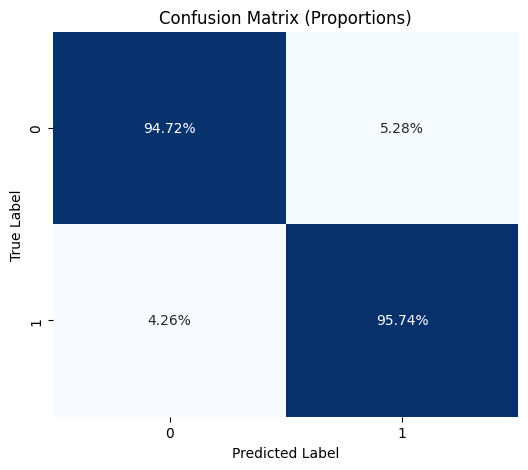

In [71]:

# -----------------------------------------------------------------
# 6) EXTRACT THE BEST MODEL & PRINT SCORES
# -----------------------------------------------------------------
print("Best parameters found:", cv.best_params_)
print("Best mean Kappa score (CV):", cv.best_score_)

best_model = cv.best_estimator_

# -----------------------------------------------------------------
# 7) EVALUATE ON VALIDATION SET
# -----------------------------------------------------------------
val_preds = best_model.predict(X_val)

kappa_val = cohen_kappa_score(y_val, val_preds)
print("Cohen Kappa on validation set:", kappa_val)

# Print classification metrics
print("\nClassification report:\n", classification_report(y_val, val_preds))

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_proportions(y_true, y_pred):
    """
    Plots a confusion matrix with proportions (row normalized), 
    displayed as percentages in a heatmap.
    """
    # Compute the standard confusion matrix (counts)
    cm = confusion_matrix(y_true, y_pred)

    # Normalize by row (actual class) to get proportions
    cm_normalized = cm / cm.sum(axis=1, keepdims=True)

    # Create a heatmap using Seaborn
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm_normalized, 
                     annot=True,       # show values
                     fmt=".2%",        # format as percentage, 2 decimal places
                     cmap="Blues",
                     cbar=False)

    # Labeling
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Confusion Matrix (Proportions)")

    plt.show()


plot_confusion_matrix_proportions(y_val, val_preds)



## Résultats
Les résultats montrent un très bon score Kappa à la fois sur les plis de validation croisée, mais également sur les données de tests qui ont été écartées de l'entrainement. Cela indique qu'il n'y a pas eu d'overfitting et le modèle généralise très bien.

### Interpretability

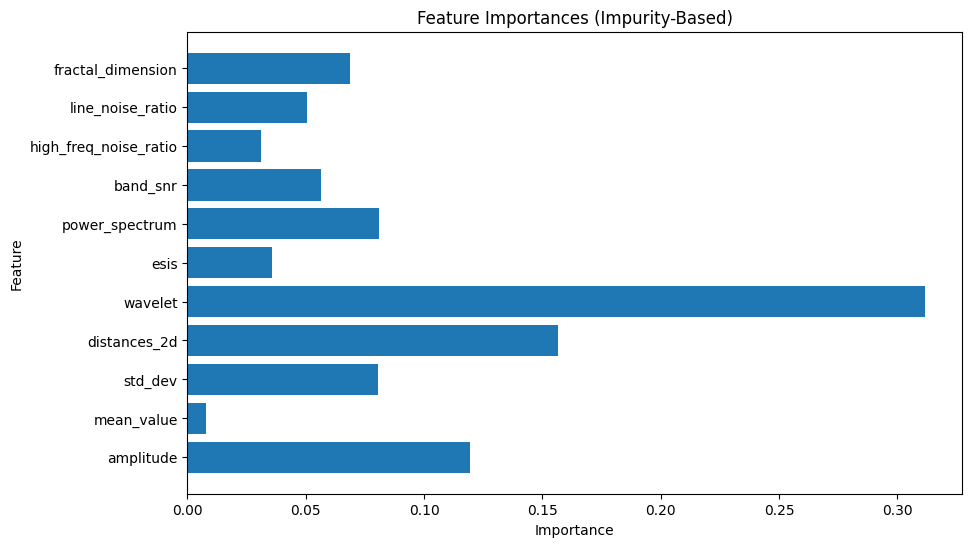

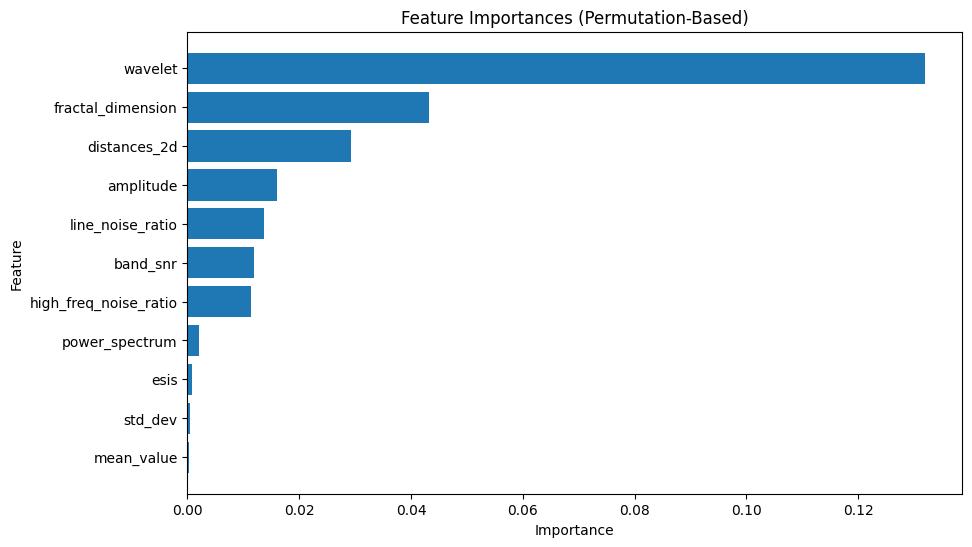

In [65]:
from sklearn.inspection import permutation_importance

# 1. Importance des caractéristiques - Basée sur l'impureté
feature_importances = best_model[1].feature_importances_
features = val_set.drop(columns=["target"]).columns

# Tracé des importances des caractéristiques (Impureté)
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Impurity-Based)')
plt.show()

# 2. Importance des caractéristiques - Permutation
perm_importance = permutation_importance(best_model, X_val, y_val, scoring='accuracy', n_repeats=10, random_state=42)
perm_sorted_idx = perm_importance.importances_mean.argsort()

# Tracé des importances des caractéristiques (Permutation)
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[perm_sorted_idx], perm_importance.importances_mean[perm_sorted_idx], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Permutation-Based)')
plt.show()



## Interprétabilité
Les graphiques comparent deux approches pour évaluer l'importance des features : basée sur l'impureté et basée sur les permutations.

- Wavelet est la feature la plus importante dans les deux méthodes, confirmant sa pertinence majeure.
- Distances_2d, fractal_dimension et amplitude jouent également un rôle significatif, surtout avec les permutations qui valorisent davantage la fractal_dimension.
- Les features comme mean_value, esis ou std_dev ont une importance marginale dans les deux approches.


En conclusion, wavelet et quelques autres (notamment fractal_dimension et distances_2d) sont essentielles, tandis que les features moins importantes pourraient être éliminées pour simplifier le modèle.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path



ROOT_TEST_PATH = Path("test/")
test_data = {i: np.load(ROOT_TEST_PATH / f"data_{i}.npy") for i in [4, 5]}

# -------------------------------------------------------------------
# 1) Format function (UNCHANGED) - ensures same final output structure
# -------------------------------------------------------------------
def format_array_to_target_format(array, record_number):
    """
    Convert a (channels, windows) prediction array into the final
    list-of-dicts format with 'identifier' and 'target'.
    """
    assert isinstance(record_number, int)
    assert isinstance(array, np.ndarray)
    assert len(array.shape) == 2
    assert array.shape[0] == 5  # if you indeed have 5 channels
    assert set(np.unique(array)) <= {0, 1}  # binary classification

    formatted_target = []
    for i in range(array.shape[0]):
        channel_encoding = (i + 1) * 100000
        record_number_encoding = record_number * 1000000
        for j in range(array.shape[1]):
            formatted_target.append(
                {
                    "identifier": record_number_encoding + channel_encoding + j,
                    "target": array[i, j],
                }
            )
    return formatted_target

# -------------------------------------------------------------------
# 2) Compute features on a single "record" (EEG array)
#    using the NEW approach, but returning the same shape.
# -------------------------------------------------------------------
def compute_features_on_record(data):
    """
    1. Filter the data (same as old code).
    2. Reshape into 2-second windows.
    3. Compute features for each channel × window using new feature pipeline logic.
       We'll gather one feature-row per (channel, window).
    4. Return a 3D array of shape (channels, windows, num_features)
       so that predictions can be made channel-wise as in the old code.
    """
    # STEP A: Bandpass filter (same as old code logic)
    filtered_data = butter_bandpass_filter(data, 0.1, 18, 250, order=4)  
    # `data` shape assumed to be (channels, samples).

    # STEP B: Reshape into 2-sec windows
    # E.g. for 2 seconds at fs=250, each window has 500 samples
    # Suppose 'reshape_signal_into_windows' returns shape (channels, windows, 500)
    reshaped_data = reshape_signal_into_windows(filtered_data, 250, 2)


    # Pseudocode for your new feature approach:
    # For each channel:
    #   For each window:
    #       - Extract the raw waveform: shape (500,)
    #       - Compute features -> dictionary -> 1D feature row
    #       - Collect into a list
    #   -> shape (windows, num_features) for that channel
    # Then stack channels -> (channels, windows, num_features)

    all_channel_features = []

    num_channels = reshaped_data.shape[0]
    num_windows = reshaped_data.shape[1]

    for ch in range(num_channels):
        channel_feature_rows = []
        for w in range(num_windows):
            window_signal = reshaped_data[ch, w, :]  # shape = (500,)
            window_signal = window_signal.reshape(1, -1)  # shape = (1, 500)
            window_signal_features = build_training_dataframe(window_signal, np.array([0]), feature_functions)
            window_signal_features = window_signal_features.drop(columns=["target"]).values # shape (1, num_features)
            # resize features to (feature_number ,)
            window_signal_features = window_signal_features.reshape(-1)
            channel_feature_rows.append(window_signal_features)  # shape (num_features,)

        channel_feature_rows = np.array(channel_feature_rows)  # (windows, num_features)
        all_channel_features.append(channel_feature_rows)

    all_channel_features = np.array(all_channel_features)  # (channels, windows, num_features)
    return all_channel_features

# -------------------------------------------------------------------
# 3) Compute predictions on a single record
#    using the best model + new features, but returning
#    shape (channels, windows) of predictions
# -------------------------------------------------------------------
def compute_predictions_on_record(data, best_model):
    """
    1. Compute features via compute_features_on_record (3D array).
    2. Flatten each channel × window into a row for best_model.predict.
    3. Reshape predictions back to (channels, windows).
    """
    all_channel_features = compute_features_on_record(data)  
    # shape = (channels, windows, num_features)

    channels, windows, num_features = all_channel_features.shape

    # Flatten to (channels * windows, num_features)
    reshaped_for_model = all_channel_features.reshape(channels * windows, num_features)

    # Pass to best_model.predict -> shape (channels*windows,)
    all_preds_flat = best_model.predict(reshaped_for_model)

    # Reshape back: (channels, windows)
    all_preds = all_preds_flat.reshape(channels, windows)
    return all_preds

# -------------------------------------------------------------------
# 4) Main loop: format results & save CSV
# -------------------------------------------------------------------
results = []
for record_number, data in test_data.items():
    # data shape presumably (channels, samples)
    preds = compute_predictions_on_record(data, best_model)  # shape (channels, windows)
    formatted_preds = format_array_to_target_format(preds, record_number)
    results.extend(formatted_preds)

df = pd.DataFrame(results)
df.to_csv("submission.csv", index=False)




Done! The submission.csv is formatted exactly like the old code,
with the same columns and shape of predictions (channels × windows).
